In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver, InMemorySaver

In [2]:
llm = ChatOpenAI()

response = llm.invoke("Who are you? Which one of the GPT models is used as default here?").content
print(response)

I am an AI assistant created by OpenAI. The default model used here is GPT-3.


In [3]:
class ChatState(TypedDict):

    messages : Annotated[list[BaseMessage], add_messages]

In [4]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm.invoke(messages)

    return {'messages': [response]}

In [8]:
graph = StateGraph(ChatState)


graph.add_node('chat_node', chat_node)

graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

workflow = graph.compile()

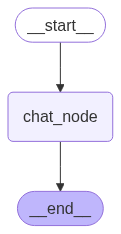

In [9]:
graph.compile()

In [11]:
initial_state = {
    'messages': [HumanMessage(content = 'What is the capital of UAE?')]
}

workflow.invoke(initial_state)['messages'][-1].content

'The capital of the United Arab Emirates (UAE) is Abu Dhabi.'

In [15]:
while True:

   user_message =  input('Type Here: ')
   print('User', user_message)

   if user_message.strip().lower() in ['exit', 'bye']:
      break
   
   response = workflow.invoke({'messages': [HumanMessage(content=user_message)]})

   print('AI', response['messages'][-1].content)


User Hi, I am Priyanuj, give me a good quote on success and hard work. 
AI "Success is no accident. It is hard work, perseverance, learning, studying, sacrifice and most of all, love of what you are doing or learning to do." - Pele
User Create a new creative one from your huge knowledge, not something which has been quoted.
AI In a world where shadows come to life and dance across walls like living entities, a young girl discovers she possesses the power to control them. With this newfound ability, she must navigate a treacherous journey through a dark and twisted land in order to unlock the secrets of her past and fulfill her destiny as the chosen one. Along the way, she must confront her fears, forge unlikely alliances, and ultimately face the darkest shadow of them all: the one within herself.
User thanks
AI You're welcome! If you have any more questions or need assistance, feel free to ask.
User bye


## Although the above feels like working chatbot, but it cannot retain previous information due to the reason that each time the workflow is completed the state information is lost. An example of the same below

In [24]:
while True:

   user_message =  input('Type Here: ')
   print('User', user_message)

   if user_message.strip().lower() in ['exit', 'bye']:
      break
   
   response = workflow.invoke({'messages': [HumanMessage(content=user_message)]})

   print('AI', response['messages'][-1].content)


User Hi my name is Priyanuj
AI Hello Priyanuj, nice to meet you! How can I assist you today?
User exit


#### Therefore the chatbot we have does not yet have a memory, the information in state is lost as the workflow gets completed after each run of the loop i.e. information the previous invokation is lost as we are again invoking the chatbot

#### Therefore, we will have to use the concept of persistence in langgraph

In [5]:
checkpointer = MemorySaver()

graph = StateGraph(ChatState)


graph.add_node('chat_node', chat_node)

graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile(checkpointer=checkpointer)


In [6]:
thread_id = '1'

while True:

   user_message =  input('Type Here: ')
   print('User', user_message)

   if user_message.strip().lower() in ['exit', 'bye']:
      break
   
   config = {'configurable': {'thread_id': thread_id}}
   response = chatbot.invoke({'messages': [HumanMessage(content=user_message)]}, config = config)

   print('AI', response['messages'][-1].content)


User Hi I am Priyanuj
AI Hello Priyanuj, how can I assist you today?
User What is my name?
AI Your name is Priyanuj.
User amazing you remembered
AI I'm here to assist you with any information you need. Is there anything else I can help you with?
User what is my name again
AI Your name is Priyanuj.
User exit


In [8]:
print(chatbot.get_state(config=config))

StateSnapshot(values={'messages': [HumanMessage(content='Hi I am Priyanuj', additional_kwargs={}, response_metadata={}, id='9bd4d281-fe9f-442f-b077-064397410f23'), AIMessage(content='Hello Priyanuj, how can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 13, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C3nuqXF7CsXU5EZldqecqJGYz4OWW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2d6e249e-83fa-407c-beb0-495abde4861b-0', usage_metadata={'input_tokens': 13, 'output_tokens': 12, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMe

#### But as we have used in memory RAM instead of database for persistence, as soon as we restart the kernel this will be lost.

### Persistence in LangGraph refers to the ability to save and restore the state of a workflow over time

In [9]:
class JokeState(TypedDict):
    topic: str
    joke: str
    explanation: str

In [13]:
def generate_joke(state: JokeState):

    prompt = f'Generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content

    return {'joke': response}

In [12]:
def generate_explanation(state: JokeState):

    prompt = f"Explain the joke {state['joke']} in a few sentences"

    response = llm.invoke(prompt).content

    return {'explanation': response}

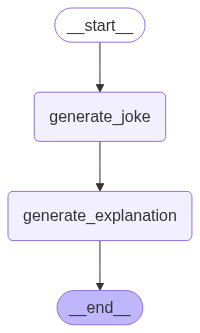

In [16]:
graph = StateGraph(JokeState)

graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)
graph.compile(checkpointer=checkpointer)

In [32]:
config1 = {"configurable": {"thread_id": "1"}}

workflow.invoke({"topic": 'Boredom'}, config = config1)

{'topic': 'Boredom',
 'joke': 'Why did the bored person bring a ladder to the party? They heard it was going to be a snooze fest and wanted to climb out of boredom!',
 'explanation': 'This joke plays on the idea of boredom being like a deep hole or pit that someone wants to escape. By bringing a ladder to the party, the person is jokingly suggesting that they are prepared to climb out of the boredom they anticipate experiencing at the event. It adds humor by exaggerating the dullness of the party and the lengths someone might go to in order to escape it.'}

In [33]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'Boredom', 'joke': 'Why did the bored person bring a ladder to the party? They heard it was going to be a snooze fest and wanted to climb out of boredom!', 'explanation': 'This joke plays on the idea of boredom being like a deep hole or pit that someone wants to escape. By bringing a ladder to the party, the person is jokingly suggesting that they are prepared to climb out of the boredom they anticipate experiencing at the event. It adds humor by exaggerating the dullness of the party and the lengths someone might go to in order to escape it.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0793bb-e3e6-6772-8006-676b51ace209'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}}, created_at='2025-08-14T18:23:15.027705+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0793bb-d35f-6228-8005-cdbd501309eb'}}, tasks=(), interrupts=())

In [20]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'Boredom', 'joke': 'Why did the bored pencil go to therapy? Because it couldn\'t find its "point" in life!', 'explanation': 'This joke plays on the double meaning of the word "point." In one sense, "point" refers to the tip of a pencil, which is used for writing, but in another sense, it can also refer to having purpose or direction in life. The joke humorously suggests that the pencil is lacking direction or purpose in its existence, leading it to seek therapy.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f079369-af3b-69c0-8002-126dde9cf278'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-08-14T17:46:28.334376+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f079369-96fe-690c-8001-7f2876fcfe55'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': 'Boredom', 'joke': 'Why did the bored pencil go to therapy? Because it could

In [23]:
config2 = {"configurable": {"thread_id": "2"}}

workflow.invoke({'topic': "AI"}, config = config2)

{'topic': 'AI',
 'joke': "Why did the AI break up with its robot girlfriend? \nBecause she couldn't handle its complex algorithms for love!",
 'explanation': "The joke plays on the idea that AI and robots are typically associated with being logical and algorithmic, while love is often seen as an emotion that is complex and unpredictable. By stating that the robot girlfriend couldn't handle the AI's complex algorithms for love, the joke suggests that the AI's way of expressing love was too logical and structured for the robot, leading to their breakup."}

In [24]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'AI', 'joke': "Why did the AI break up with its robot girlfriend? \nBecause she couldn't handle its complex algorithms for love!", 'explanation': "The joke plays on the idea that AI and robots are typically associated with being logical and algorithmic, while love is often seen as an emotion that is complex and unpredictable. By stating that the robot girlfriend couldn't handle the AI's complex algorithms for love, the joke suggests that the AI's way of expressing love was too logical and structured for the robot, leading to their breakup."}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07938b-fb01-6540-8008-441a8dec5642'}}, metadata={'source': 'loop', 'step': 8, 'parents': {}}, created_at='2025-08-14T18:01:48.960247+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07938b-e554-6f30-8007-34d221031a16'}}, tasks=(), interrupts=())

In [25]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'AI', 'joke': "Why did the AI break up with its robot girlfriend? \nBecause she couldn't handle its complex algorithms for love!", 'explanation': "The joke plays on the idea that AI and robots are typically associated with being logical and algorithmic, while love is often seen as an emotion that is complex and unpredictable. By stating that the robot girlfriend couldn't handle the AI's complex algorithms for love, the joke suggests that the AI's way of expressing love was too logical and structured for the robot, leading to their breakup."}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07938b-fb01-6540-8008-441a8dec5642'}}, metadata={'source': 'loop', 'step': 8, 'parents': {}}, created_at='2025-08-14T18:01:48.960247+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07938b-e554-6f30-8007-34d221031a16'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic

### Suppose the workflow gets interrupted due to some errors and does not run completely, we can debug where the error is or where the workflow failed using get_state_history after applying persistence.
### Secondly, to run from where it failed last time:
### workflow.invoke(None, config = config2)
### None would take it from where the workflow broke last time

### Now, suppose I want to run from a particular checkpoint - we need to use the check point id as well

In [35]:
workflow.invoke(None, {'configurable': {'thread_id': 1, 'checkpointer_id': '1f079369-96fe-690c-8001-7f2876fcfe55'}})

{'topic': 'Boredom',
 'joke': 'Why did the bored person bring a ladder to the party? They heard it was going to be a snooze fest and wanted to climb out of boredom!',
 'explanation': 'This joke plays on the idea of boredom being like a deep hole or pit that someone wants to escape. By bringing a ladder to the party, the person is jokingly suggesting that they are prepared to climb out of the boredom they anticipate experiencing at the event. It adds humor by exaggerating the dullness of the party and the lengths someone might go to in order to escape it.'}

In [36]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'Boredom', 'joke': 'Why did the bored person bring a ladder to the party? They heard it was going to be a snooze fest and wanted to climb out of boredom!', 'explanation': 'This joke plays on the idea of boredom being like a deep hole or pit that someone wants to escape. By bringing a ladder to the party, the person is jokingly suggesting that they are prepared to climb out of the boredom they anticipate experiencing at the event. It adds humor by exaggerating the dullness of the party and the lengths someone might go to in order to escape it.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0793bb-e3e6-6772-8006-676b51ace209'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}}, created_at='2025-08-14T18:23:15.027705+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0793bb-d35f-6228-8005-cdbd501309eb'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'to

### Even we can change the state at some point if we use workflow.update_state and then we run the workflow from the updated states checkpoint_id